In [1]:
import os
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import Image
import sklearn
from sklearn import preprocessing
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
print(tf.__version__)
#limit GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

2.0.0


In [2]:
val_dir = "./dogs-cats-images/dataset/test_set/"
train_dir = "./dogs-cats-images/dataset/training_set/"
print(os.path.exists(val_dir))
print(os.path.exists(train_dir))

True
True


In [3]:
#config input images
height = 224
width = 224
channels = 3
batch_size = 24
num_class = 2
class_name = ['cat','dog']
img_size = (width,height)

In [4]:
#callbacks
logdir = './callbacks_resnet'
if not os.path.exists:
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,'cat_dog_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,factor=0.5,min_lr=0.00001)  
]

In [5]:
train_data_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,#增加位移鲁棒性
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',    
)

val_data_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input
)

In [6]:
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(height,width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

val_generator = val_data_gen.flow_from_directory(
    val_dir,
    target_size=(height,width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)


train_num = train_generator.samples
val_num = val_generator.samples

Found 8000 images belonging to 2 classes.
Found 1954 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


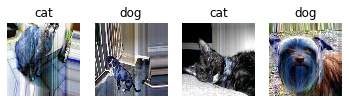

In [7]:
plt.figure()
for i in range(4):
    plt.subplot(1,4,i+1)
    for x_batch,y_batch in train_generator:
        image = x_batch[0]
        M_scaler = preprocessing.MinMaxScaler()
        for i in range(3):
            image[:,:,i] = M_scaler.fit_transform(image[:,:,i])
        plt.imshow(image)
        plt.title(class_name[y_batch.astype(np.int8)[0][1]])
        plt.axis('off')
        break
        
plt.show()

In [8]:
resnet50 = keras.models.Sequential()
resnet50.add(keras.applications.ResNet50(include_top = False,
                                        pooling = 'avg',
                                        weights = 'imagenet'))
resnet50.add(keras.layers.Dense(num_class,activation='softmax'))

resnet50.layers[0].trainable=False

In [9]:
resnet50.compile(loss=keras.losses.categorical_crossentropy,
             optimizer='adam',metrics=['accuracy'])
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
epochs = 5
history = resnet50.fit_generator(train_generator,
                                 epochs=epochs,
                                 validation_data=val_generator,
                                 validation_steps=val_num//batch_size,
                                 steps_per_epoch=train_num//batch_size,
                                 callbacks=callbacks)

Epoch 1/5
 14/333 [>.............................] - ETA: 2:50 - loss: 0.4678 - accuracy: 0.7738

In [11]:
def plot_learning_curve(history,label):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8,5))
    plt.show()

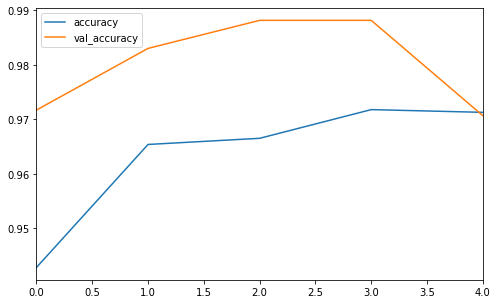

In [12]:
plot_learning_curve(history,'accuracy')

In [13]:
#Test data
test_dir =  "./dogs-cats-images/dataset/mix/"
test_filename = os.listdir(test_dir)
print(os.path.exists(test_dir))

True


In [14]:
#test_generator
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

In [26]:
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
)
nb_sample = test_generator.samples
nb_sample

Found 198 images belonging to 2 classes.


198

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict:cat


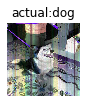

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict:dog


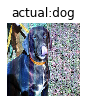

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict:dog


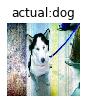

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict:cat


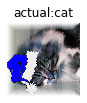

In [28]:
plt.figure()
for i in range(4):
    plt.subplot(1,4,i+1)
    for x_batch,y_batch in test_generator:
        image = x_batch[0]
        pred = resnet50.predict(image.reshape((-1,224,224,3)))
        print('Predict:%s'%class_name[pred.argmax(axis=1).astype(np.int8)[0]])
        M_scaler = preprocessing.MinMaxScaler()
        for i in range(3):
            image[:,:,i] = M_scaler.fit_transform(image[:,:,i])
        plt.imshow(image)
        plt.title('actual:%s'%class_name[y_batch.astype(np.int8)[0][1]])
        plt.axis('off')
        break        
    plt.show()